In [1]:
import pandas as pd
# pandas show all columns of table instead of restricted#
pd.set_option('display.max_columns', None)
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np
import math

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin


from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig#, Inspection, Manipulation, Correction
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))
# inspect=Inspection()
# manipulate=Manipulation()
# correct=Correction()


from eda_quality import correction as correct
from eda_quality import manipulation as manipulate
from eda_quality import inspection as inspect


In [2]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=40) 

In [3]:
correct.drop_dublicates(track_df)
track_df.head()

Deleted rows:  186


,id,time,geometry,Engine Load.value,Engine Load.unit,Calculated MAF.value,Calculated MAF.unit,Speed.value,Speed.unit,CO2.value,CO2.unit,Intake Pressure.value,Intake Pressure.unit,Rpm.value,Rpm.unit,Intake Temperature.value,Intake Temperature.unit,Consumption (GPS-based).value,Consumption (GPS-based).unit,GPS Altitude.value,GPS Altitude.unit,Throttle Position.value,Throttle Position.unit,GPS Bearing.value,GPS Bearing.unit,Consumption.value,Consumption.unit,GPS Accuracy.value,GPS Accuracy.unit,CO2 Emission (GPS-based).value,CO2 Emission (GPS-based).unit,GPS Speed.value,GPS Speed.unit,track.id,track.length,track.begin,track.end,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer,track.appVersion,track.touVersion,GPS HDOP.value,GPS HDOP.unit,GPS PDOP.value,GPS PDOP.unit,GPS VDOP.value,GPS VDOP.unit,MAF.value,MAF.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5f0ef89c00375c5a2641ef86,2020-07-15T12:37:03+00:00,POINT (7.57939 51.96766),30.459892,%,3.113889,g/s,15.978930,km/h,2.405470,kg/h,29.667201,kPa,748.952252,u/min,26.000000,c,0.936199,l/h,115.671012,m,13.000000,%,136.590329,deg,1.023604,l/h,6.000000,%,2.200068,kg/h,17.502660,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f0ef89c00375c5a2641ef88,2020-07-15T12:37:09+00:00,POINT (7.57955 51.96757),49.230105,%,9.778811,g/s,11.134565,km/h,7.554102,kg/h,47.232322,kPa,1475.604745,u/min,25.652838,c,0.937457,l/h,115.280639,m,16.642229,%,134.479803,deg,3.214511,l/h,6.000000,%,2.203025,kg/h,10.324164,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f0ef89c00375c5a2641ef89,2020-07-15T12:37:14+00:00,POINT (7.57988 51.96740),78.649652,%,25.066406,g/s,33.976330,km/h,19.363722,kg/h,74.040426,kPa,2397.395931,u/min,23.728013,c,5.102906,l/h,114.613231,m,23.862069,%,123.313954,deg,8.239881,l/h,6.193485,%,11.991830,kg/h,30.967132,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5f0ef89c00375c5a2641ef8a,2020-07-15T12:37:19+00:00,POINT (7.58049 51.96715),31.200400,%,7.419664,g/s,39.000000,km/h,5.731668,kg/h,30.075758,kPa,1748.565672,u/min,24.000000,c,2.280491,l/h,113.835218,m,15.351261,%,125.035780,deg,2.439007,l/h,6.000000,%,5.359154,kg/h,36.898346,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5f0ef89c00375c5a2641ef8b,2020-07-15T12:37:24+00:00,POINT (7.58107 51.96682),29.735773,%,3.106679,g/s,34.321667,km/h,2.399900,kg/h,29.000000,kPa,761.854074,u/min,25.000000,c,0.946257,l/h,113.502384,m,13.000000,%,133.482068,deg,1.021234,l/h,7.489919,%,2.223704,kg/h,34.447545,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Get subset of numerical data

In [4]:
track_df_numeric=track_df.select_dtypes('float64')
track_df_numeric.head()

,Engine Load.value,Calculated MAF.value,Speed.value,CO2.value,Intake Pressure.value,Rpm.value,Intake Temperature.value,Consumption (GPS-based).value,GPS Altitude.value,Throttle Position.value,GPS Bearing.value,Consumption.value,GPS Accuracy.value,CO2 Emission (GPS-based).value,GPS Speed.value,track.length,GPS HDOP.value,GPS PDOP.value,GPS VDOP.value,MAF.value,O2 Lambda Voltage ER.value,O2 Lambda Voltage.value
0,30.459892,3.113889,15.978930,2.405470,29.667201,748.952252,26.000000,0.936199,115.671012,13.000000,136.590329,1.023604,6.000000,2.200068,17.502660,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
1,49.230105,9.778811,11.134565,7.554102,47.232322,1475.604745,25.652838,0.937457,115.280639,16.642229,134.479803,3.214511,6.000000,2.203025,10.324164,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
2,78.649652,25.066406,33.976330,19.363722,74.040426,2397.395931,23.728013,5.102906,114.613231,23.862069,123.313954,8.239881,6.193485,11.991830,30.967132,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
3,31.200400,7.419664,39.000000,5.731668,30.075758,1748.565672,24.000000,2.280491,113.835218,15.351261,125.035780,2.439007,6.000000,5.359154,36.898346,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
4,29.735773,3.106679,34.321667,2.399900,29.000000,761.854074,25.000000,0.946257,113.502384,13.000000,133.482068,1.021234,7.489919,2.223704,34.447545,0.665466,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
track_df['index']=track_df.index
track_df.head()

,id,time,geometry,Engine Load.value,Engine Load.unit,Calculated MAF.value,Calculated MAF.unit,Speed.value,Speed.unit,CO2.value,CO2.unit,Intake Pressure.value,Intake Pressure.unit,Rpm.value,Rpm.unit,Intake Temperature.value,Intake Temperature.unit,Consumption (GPS-based).value,Consumption (GPS-based).unit,GPS Altitude.value,GPS Altitude.unit,Throttle Position.value,Throttle Position.unit,GPS Bearing.value,GPS Bearing.unit,Consumption.value,Consumption.unit,GPS Accuracy.value,GPS Accuracy.unit,CO2 Emission (GPS-based).value,CO2 Emission (GPS-based).unit,GPS Speed.value,GPS Speed.unit,track.id,track.length,track.begin,track.end,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer,track.appVersion,track.touVersion,GPS HDOP.value,GPS HDOP.unit,GPS PDOP.value,GPS PDOP.unit,GPS VDOP.value,GPS VDOP.unit,MAF.value,MAF.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit,index
0,5f0ef89c00375c5a2641ef86,2020-07-15T12:37:03+00:00,POINT (7.57939 51.96766),30.459892,%,3.113889,g/s,15.978930,km/h,2.405470,kg/h,29.667201,kPa,748.952252,u/min,26.000000,c,0.936199,l/h,115.671012,m,13.000000,%,136.590329,deg,1.023604,l/h,6.000000,%,2.200068,kg/h,17.502660,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,5f0ef89c00375c5a2641ef88,2020-07-15T12:37:09+00:00,POINT (7.57955 51.96757),49.230105,%,9.778811,g/s,11.134565,km/h,7.554102,kg/h,47.232322,kPa,1475.604745,u/min,25.652838,c,0.937457,l/h,115.280639,m,16.642229,%,134.479803,deg,3.214511,l/h,6.000000,%,2.203025,kg/h,10.324164,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,5f0ef89c00375c5a2641ef89,2020-07-15T12:37:14+00:00,POINT (7.57988 51.96740),78.649652,%,25.066406,g/s,33.976330,km/h,19.363722,kg/h,74.040426,kPa,2397.395931,u/min,23.728013,c,5.102906,l/h,114.613231,m,23.862069,%,123.313954,deg,8.239881,l/h,6.193485,%,11.991830,kg/h,30.967132,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,5f0ef89c00375c5a2641ef8a,2020-07-15T12:37:19+00:00,POINT (7.58049 51.96715),31.200400,%,7.419664,g/s,39.000000,km/h,5.731668,kg/h,30.075758,kPa,1748.565672,u/min,24.000000,c,2.280491,l/h,113.835218,m,15.351261,%,125.035780,deg,2.439007,l/h,6.000000,%,5.359154,kg/h,36.898346,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,5f0ef89c00375c5a2641ef8b,2020-07-15T12:37:24+00:00,POINT (7.58107 51.96682),29.735773,%,3.106679,g/s,34.321667,km/h,2.399900,kg/h,29.000000,kPa,761.854074,u/min,25.000000,c,0.946257,l/h,113.502384,m,13.000000,%,133.482068,deg,1.021234,l/h,7.489919,%,2.223704,kg/h,34.447545,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


#### Inspect categorical vairables
As we want to create dummy varaibles for the categorical variables, we will first inspect each categorical
variable.

<AxesSubplot:>

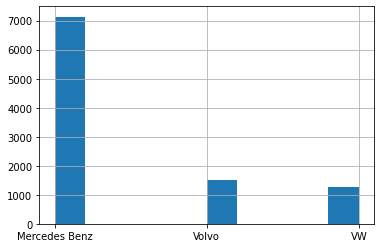

In [6]:
track_df['sensor.manufacturer'].hist()

<AxesSubplot:>

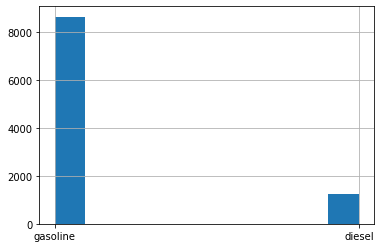

In [7]:
track_df['sensor.fuelType'].hist()

<AxesSubplot:>

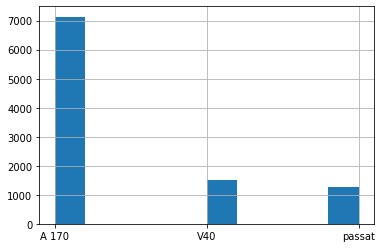

In [8]:
track_df['sensor.model'].hist()

#### Simple Preprocessing for only numerical variables

In [9]:
# take only numerical variables
track_df_numeric = track_df.select_dtypes(['float64']).copy()
track_df_numeric['index']=track_df_numeric.index
track_df_numeric

,Engine Load.value,Calculated MAF.value,Speed.value,CO2.value,Intake Pressure.value,Rpm.value,Intake Temperature.value,Consumption (GPS-based).value,GPS Altitude.value,Throttle Position.value,GPS Bearing.value,Consumption.value,GPS Accuracy.value,CO2 Emission (GPS-based).value,GPS Speed.value,track.length,GPS HDOP.value,GPS PDOP.value,GPS VDOP.value,MAF.value,O2 Lambda Voltage ER.value,O2 Lambda Voltage.value,index
0,30.459892,3.113889,15.978930,2.405470,29.667201,748.952252,26.000000,0.936199,115.671012,13.000000,136.590329,1.023604,6.000000,2.200068,17.502660,0.665466,NaN,NaN,NaN,NaN,NaN,NaN,0
1,49.230105,9.778811,11.134565,7.554102,47.232322,1475.604745,25.652838,0.937457,115.280639,16.642229,134.479803,3.214511,6.000000,2.203025,10.324164,0.665466,NaN,NaN,NaN,NaN,NaN,NaN,1
2,78.649652,25.066406,33.976330,19.363722,74.040426,2397.395931,23.728013,5.102906,114.613231,23.862069,123.313954,8.239881,6.193485,11.991830,30.967132,0.665466,NaN,NaN,NaN,NaN,NaN,NaN,2
3,31.200400,7.419664,39.000000,5.731668,30.075758,1748.565672,24.000000,2.280491,113.835218,15.351261,125.035780,2.439007,6.000000,5.359154,36.898346,0.665466,NaN,NaN,NaN,NaN,NaN,NaN,3
4,29.735773,3.106679,34.321667,2.399900,29.000000,761.854074,25.000000,0.946257,113.502384,13.000000,133.482068,1.021234,7.489919,2.223704,34.447545,0.665466,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,9.326804,NaN,19.129159,NaN,102.000003,896.473427,20.000000,NaN,105.332338,83.000002,286.150509,NaN,9.000000,NaN,21.100599,4.927578,0.7,1.0,0.7,7.889674,0.251472,0.901622,183
184,64.046135,NaN,22.405573,NaN,124.506395,1641.410206,20.000000,NaN,106.999998,83.000000,259.085665,NaN,3.000000,NaN,19.851210,4.927578,0.7,1.0,0.7,24.219399,0.080206,0.239554,184
185,53.263886,NaN,28.234810,NaN,105.523416,1306.598197,20.000000,NaN,108.999998,77.916939,277.207013,NaN,3.000000,NaN,28.178921,4.927578,0.7,1.0,0.7,13.331896,0.228385,0.791607,185
186,49.906349,NaN,42.380618,NaN,111.729384,1368.327784,20.000000,NaN,109.999997,82.939757,274.954785,NaN,4.000000,NaN,41.153397,4.927578,0.8,1.1,0.8,16.698604,0.091821,0.355761,186


### Preprocessing pipeline for complete dataframe

We create our preprocessing pipeline and apply it on the dataframe.
Here we do a simple median imputation and apply feature scaling in our pipeline.

In [10]:
pipeline_numerical = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# this returns a numpy array
tracksPiped=pipeline_numerical.fit_transform(track_df_numeric)

In [11]:
# numpy array to pandas dataframe
tracksPiped = pd.DataFrame(tracksPiped, columns=track_df_numeric.columns, index=track_df_numeric['index'])
tracksPiped.head()

,Engine Load.value,Calculated MAF.value,Speed.value,CO2.value,Intake Pressure.value,Rpm.value,Intake Temperature.value,Consumption (GPS-based).value,GPS Altitude.value,Throttle Position.value,GPS Bearing.value,Consumption.value,GPS Accuracy.value,CO2 Emission (GPS-based).value,GPS Speed.value,track.length,GPS HDOP.value,GPS PDOP.value,GPS VDOP.value,MAF.value,O2 Lambda Voltage ER.value,O2 Lambda Voltage.value,index
index,,,,,,,,,,,,,,,,,,,,,,,
0,-0.728065,-1.491220,-1.127799,-1.296911,-1.107508,-1.317796,0.937017,-1.124054,0.253385,-0.710250,-0.352111,-1.296911,0.118764,-1.124054,-1.090968,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.104560
1,0.150085,-0.869111,-1.239049,-0.707738,-0.428085,-0.585081,0.909349,-1.121480,0.243283,-0.536774,-0.374522,-0.707738,0.118765,-1.121480,-1.259740,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.101554
2,1.526456,0.557845,-0.714492,0.643672,0.608858,0.344400,0.755943,7.400620,0.226012,-0.192902,-0.493083,0.643672,0.174931,7.400620,-0.774406,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.098548
3,-0.693421,-1.089316,-0.599124,-0.916285,-1.091705,-0.309843,0.777620,1.626235,0.205878,-0.598262,-0.474801,-0.916285,0.118764,1.626235,-0.634958,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.095542
4,-0.761942,-1.491893,-0.706561,-1.297549,-1.133315,-1.304786,0.857318,-1.103476,0.197264,-0.710250,-0.385116,-1.297549,0.551270,-1.103476,-0.692578,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.092535


### Preprocessing pipeline columnwise
Here we apply processes on specific columns in a datraframe

Create lists of colums per datatype or for which you like to  

In [12]:
attributes_numerical=list(track_df_numeric)
attributes_categorical=['sensor.fuelType','sensor.manufacturer', 'sensor.model']

Create pipeline columnwise.
Here we 'reuse' the pipeline from above for the numerical variables. However, on the categorical variables
we apply the OneHotEncoder

In [13]:
pipeline_full = ColumnTransformer([
    ("num", pipeline_numerical, attributes_numerical),
    ("cat", OneHotEncoder(), attributes_categorical),
])

Apply pipeline on dataframe
This will return a n-d numpy array

In [14]:
processedColumnwise = pipeline_full.fit_transform(track_df)

#### DF creation of numpy array
To create a dataframe from the array we need a list of appropriate names for the columns. Therefore we first create lists from the names of the categories.

In [15]:
fuelTypeList=list(map('sensor.fuelType_'.__add__,track_df['sensor.fuelType'].unique().tolist()))
manuList=list(map('sensor.manufacturer_'.__add__,track_df['sensor.manufacturer'].unique().tolist()))
modelList=list(map('sensor.model_'.__add__,track_df['sensor.model'].unique().tolist()))

Create complete column list

In [16]:
columns1=attributes_numerical+fuelTypeList+manuList+modelList

Create dataframe from array and controle per eye if data and columns are correct

In [17]:
processedColumnwise= pd.DataFrame(processedColumnwise, columns=columns1, index=track_df.index)
processedColumnwise.head()

,Engine Load.value,Calculated MAF.value,Speed.value,CO2.value,Intake Pressure.value,Rpm.value,Intake Temperature.value,Consumption (GPS-based).value,GPS Altitude.value,Throttle Position.value,GPS Bearing.value,Consumption.value,GPS Accuracy.value,CO2 Emission (GPS-based).value,GPS Speed.value,track.length,GPS HDOP.value,GPS PDOP.value,GPS VDOP.value,MAF.value,O2 Lambda Voltage ER.value,O2 Lambda Voltage.value,index,sensor.fuelType_gasoline,sensor.fuelType_diesel,sensor.manufacturer_Mercedes Benz,sensor.manufacturer_Volvo,sensor.manufacturer_VW,sensor.model_A 170,sensor.model_V40,sensor.model_passat
0,-0.728065,-1.491220,-1.127799,-1.296911,-1.107508,-1.317796,0.937017,-1.124054,0.253385,-0.710250,-0.352111,-1.296911,0.118764,-1.124054,-1.090968,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.104560,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.150085,-0.869111,-1.239049,-0.707738,-0.428085,-0.585081,0.909349,-1.121480,0.243283,-0.536774,-0.374522,-0.707738,0.118765,-1.121480,-1.259740,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.101554,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.526456,0.557845,-0.714492,0.643672,0.608858,0.344400,0.755943,7.400620,0.226012,-0.192902,-0.493083,0.643672,0.174931,7.400620,-0.774406,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.098548,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.693421,-1.089316,-0.599124,-0.916285,-1.091705,-0.309843,0.777620,1.626235,0.205878,-0.598262,-0.474801,-0.916285,0.118764,1.626235,-0.634958,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.095542,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.761942,-1.491893,-0.706561,-1.297549,-1.133315,-1.304786,0.857318,-1.103476,0.197264,-0.710250,-0.385116,-1.297549,0.551270,-1.103476,-0.692578,-1.032578,-0.066081,-0.064848,-0.067558,-0.147444,-0.082932,0.049607,-1.092535,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
